In [1]:
import someip_timing_analysis.analysis as analysis
import matplotlib.pyplot as plt
import networkx as nx

from someip_timing_analysis.entities import *
from someip_timing_analysis.graph import *
from typing import List

# Network Support

In [2]:
class Device(Node):
    """The device extends node from the G library.
    """
    def __init__(self, id: int, entities: List[Entity], base_delay: float = 0):
        """It takes as input the unique id, and the list of entities.
        Args:
            id (int): The unique id.
            entities (List[Entity]): The list of entities.
            base_delay (_type_, optional): Base software delay. Defaults to 0.
        """
        SomeIPDevice.__init__(self, id, entities)
        self.base_delay = base_delay

    def device_delay(self) -> float:
        return len(self.entities) * self.base_delay

def device_to_device_delay(G: Graph, source: Device, target: Device) -> float:
    """Get the delay between every node.

    Args:
        source (Device): Source device.
        target (Device): Target device.

    Returns:
        float: The delay between the nodes.
    """
    if source == target:
        return 0
    (weight, _) = G.find_shortest_path(source, target)
    return source.device_delay() + weight + target.device_delay()


# Scenario (SOME/IP)

In [3]:
# Load the services.
S0 = Service("S0", boot_del=2, init_del=4, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S1 = Service("S1", boot_del=1, init_del=3, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S2 = Service("S2", boot_del=4, init_del=6, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S3 = Service("S3", boot_del=2, init_del=4, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S4 = Service("S4", boot_del=1, init_del=3, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)

# Load the clients.
C0 = Client("C0", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C1 = Client("C1", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C2 = Client("C2", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C3 = Client("C3", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C4 = Client("C4", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C5 = Client("C5", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)


# Scenario (Graph)

In [4]:
# Place services and clients inside nodes.
n0 = Device(id = 0, entities = [S0, C0, C1], base_delay = 0.05)
n1 = Device(id = 1, entities = [S1, S2],     base_delay = 0.025)
n2 = Device(id = 2, entities = [S3, C2, C3], base_delay = 0.075)
n3 = Device(id = 3, entities = [S4, C4],     base_delay = 0.045)
n4 = Device(id = 4, entities = [C5],         base_delay = 0.076)

# Create the G, using weights computed using the following formula:
#   (frame_length * 8) / link_speed
# 
graph = Graph(
    connections = [
        (n0, n1, lambda G, node0, node1: ( 256 * 8) / 1e09),
        (n1, n2, lambda G, node0, node1: ( 256 * 8) / 1e06),
        (n1, n3, lambda G, node0, node1: (1024 * 8) / 1e03),
        (n3, n4, lambda G, node0, node1: ( 256 * 8) / 1e09),
        (n2, n3, lambda G, node0, node1: ( 256 * 8) / 1e06),
        (n2, n4, lambda G, node0, node1: (1024 * 8) / 1e03)
    ],
    directed = False
)


# Visualize the graph

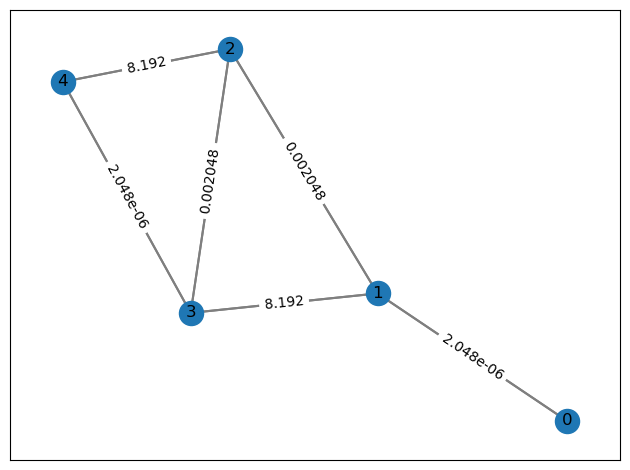

In [5]:
if graph.directed:
    G = nx.DiGraph()
else:
    G = nx.Graph()

# List of edges.
edge_list = [(source.id, target.id) for (source, target) in graph.get_edge_list()]

# List of edge labels.
edge_labels = {}
for (source, target) in graph.get_edge_list():
    edge_labels[source.id, target.id] = str(graph.get_weight(source, target))

# Add the edges.
G.add_edges_from(edge_list)
# Positions for all nodes.
pos = nx.spring_layout(G, k=1, iterations=100)
# Add the nodes.
nx.draw_networkx_nodes(G, pos, node_color="tab:blue")
# Draw the node labels.
nx.draw_networkx_labels(G, pos, font_family="sans-serif")
# Draw the edges.
nx.draw_networkx_edges(G, pos, edgelist=edge_list, width=1.5, edge_color="tab:gray")
# Draw the edges weights.
nx.draw_networkx_edge_labels(G, pos, edge_labels)
# Draw the G.
plt.tight_layout()
plt.show()

# Compute timing analysis

In [7]:
# Check where the SOME/IP entities are located.
containing_node = {}
for node in graph.graph:
    for entity in node.entities:
        containing_node[entity] = node

def create_relation(G: Graph, e0: Entity, e1: Entity) -> Relation:
    """Creates a relation between the pair of entities.

    Args:
        G (Graph): The G.
        e0 (Entity): The first entity.
        e1 (Entity): The second entity.

    Returns:
        Relation: A relation between the entities.
    """
    return Relation(e0, e1, device_to_device_delay(G, containing_node[e0], containing_node[e1]))

# Define the relations between clients and services.
system = System([
    create_relation(graph, C0, S3),
    create_relation(graph, C0, S4),
    create_relation(graph, C1, S0),
    create_relation(graph, C2, S4),
    create_relation(graph, C3, S4),
    create_relation(graph, C3, S0),
    create_relation(graph, C4, S1),
    create_relation(graph, C5, S0)
])

# Compute the worst-case discovery time.
analysis.get_highest_discovery_time(system)


[16:01:53][timing        ][INFO    ] (c) Service in Offer Mode and Client in Request Mode
[16:01:53][timing        ][DEBUG   ] compute_z_c(c.boot_del: 3.00, s.t_init: 6.00) -> 0.00
[16:01:53][timing        ][DEBUG   ] compute_x_c(z_c: 0.00, t_c: 0.38, s.rep_del: 1.00) -> 0
[16:01:53][timing        ][DEBUG   ] compute_x_c_hat(s.rep_max: 3, x_c: 0) -> 0
[16:01:53][timing        ][DEBUG   ] compute_t_rep(e.rep_del: 1.00, x: 0) -> 0.00
[16:01:53][timing        ][DEBUG   ] compute_z_c(c.boot_del: 3.00, s.t_init: 6.00) -> 0.00
[16:01:53][timing        ][DEBUG   ] compute_t_rep(e.rep_del: 1.00, x: 3) -> 7.00
[16:01:53][timing        ][DEBUG   ] compute_y(z_c: 0.00, t_c: 0.38, t_rep: 7.00, s.cyc_del: 2.00) -> -3
[16:01:53][timing        ][DEBUG   ] compute_z_c(c.boot_del: 3.00, s.t_init: 6.00) -> 0.00
[16:01:53][timing        ][DEBUG   ] compute_x_c(z_c: 0.00, t_c: 0.38, s.rep_del: 1.00) -> 0
[16:01:53][timing        ][DEBUG   ] compute_x_c_hat(s.rep_max: 3, x_c: 0) -> 0
[16:01:53][timing     

14.420050048000002

# Graph to CSV

In [ ]:
# We save the current G.
Graph.write_to_csv(graph, "test.csv")
# We load the G from file.
G1 = Graph.read_from_csv("test.csv")
print(graph)
print(G1)